Question:

H0: Discounts do not have significant impact on Quantity

Ha: Discounts do have a significant Impact on Quantity

a = .05

In [3]:
##Importing SQLlite to load the data set and eventually put into a DF for ease of sampling.
import sqlite3 
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

In [4]:
##Using pandas to fetchall everything into a DF.
import pandas as pd
cur.execute("""SELECT Quantity, Discount FROM OrderDetail;""")
df1 = pd.DataFrame(cur.fetchall())
df1.columns = [x[0] for x in cur.description]
df1.head()

,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0
3,9,0.0
4,40,0.0


In [5]:
#Creating a Sample of all quantities purchased on items where there is no discount.
import numpy as np
no_discount = pd.DataFrame(cur.execute("""SELECT Quantity FROM OrderDetail WHERE Discount = 0.0;"""))

In [6]:
no_discount.info

<bound method DataFrame.info of        0
0     12
1     10
2      5
3      9
4     40
...   ..
1312   2
1313   2
1314   1
1315   4
1316   2

[1317 rows x 1 columns]>

In [7]:
#Creating a sample array of values for quantties purchased if the item was discounted at any rate.
discounted = pd.DataFrame(cur.execute("""SELECT Quantity FROM OrderDetail WHERE Discount != 0.0;"""))
discounted.info

<bound method DataFrame.info of       0
0    35
1    15
2     6
3    15
4    40
..   ..
833   2
834   3
835   2
836   2
837   2

[838 rows x 1 columns]>

In [8]:
#Checking for normality in both of my sample populations using wilks-shapiro test.
from scipy import stats
from scipy.stats import shapiro
data = no_discount
data2 = discounted
stat, p = shapiro(data)
print(stats.shapiro(data), stats.shapiro(data2))

(0.8434571027755737, 3.803856556577728e-34) (0.8690301179885864, 6.88120409395894e-26)


Neither sample returns a P-value less than the alpha to reject the null hypothesis that the data is normal.

I have now pulled my data, isolated samples based on discount value, and failed my normality test. Going to visualize the data first and then try to force normalization.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a215d27d0>]],
      dtype=object)

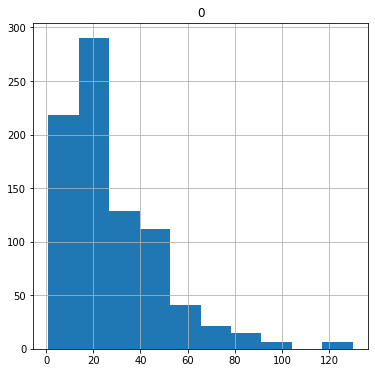

In [57]:
#Visualizing the data.
import matplotlib.pyplot as plt
discounted.hist(figsize = [6, 6])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2031d5d0>]],
      dtype=object)

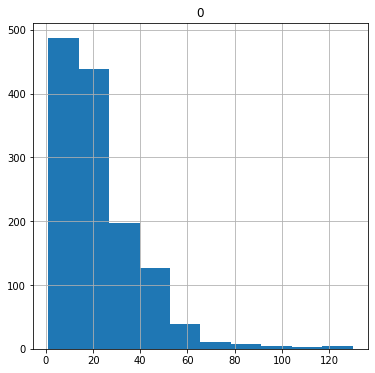

In [10]:
no_discount.hist(figsize = [6, 6])

(0.9908283948898315, 0.010506429709494114) (array([15., 14., 39., 82., 74., 82., 79., 22.,  6.,  6.]), array([-2.50907916, -1.98733314, -1.46558712, -0.94384111, -0.42209509,
        0.09965093,  0.62139695,  1.14314296,  1.66488898,  2.186635  ,
        2.70838102]), <a list of 10 Patch objects>)


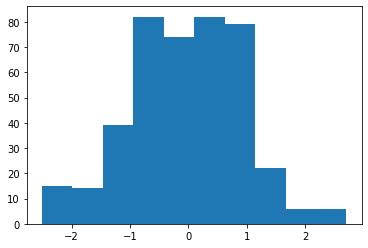

In [11]:
#Performing logorithmic transformation to normalize the data.
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
yj = PowerTransformer(method='yeo-johnson')
X_train, X_test = train_test_split(discounted, test_size=.5)
discounted_yj = yj.fit(X_train).transform(X_test)
#discounted_log = np.log(discounted)
print(stats.shapiro(discounted_yj), plt.hist(discounted_yj))

(0.9904764294624329, 0.00029053742764517665) (array([ 17.,  68.,  72., 153., 116., 137.,  58.,  27.,   5.,   6.]), array([-2.32768566, -1.78018253, -1.23267941, -0.68517628, -0.13767315,
        0.40982997,  0.9573331 ,  1.50483623,  2.05233935,  2.59984248,
        3.14734561]), <a list of 10 Patch objects>)


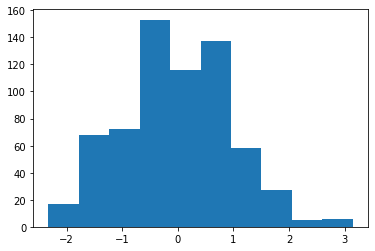

In [12]:
#Replicating the transformation on the non-discounted quantities.
#no_discount_log = np.log(no_discount)
Y_train, Y_test = train_test_split(no_discount, test_size=.5)
no_discount_yj = yj.fit(Y_train).transform(Y_test)
print(stats.shapiro(no_discount_yj), plt.hist(no_discount_yj))

In [15]:
# seed the random number generator so I get the same results
np.random.seed(10)

#Mean height and sd for discounted quantities
discounted_mean = discounted.mean()
discounted_sd = discounted.std()

# Generate a normal distribution for discounted quantities
discounted_rv = scipy.stats.norm(discounted_mean, discounted_sd)

In [16]:
#Mean height and sd for non-discounted quantities
no_discount_mean = no_discount.mean()
no_discount_sd = no_discount.std()


# Generate a normal distribution for non-discounted quantities
no_discount_rv = scipy.stats.norm(no_discount_mean, no_discount_sd)

In [17]:
print(no_discount_mean, no_discount_sd, discounted_mean, discounted_sd)

0    21.715262
dtype: float64 0    17.507493
dtype: float64 0    27.109785
dtype: float64 0    20.771439
dtype: float64


In [18]:
import scipy.stats
%matplotlib inline
def evaluate_PDF(rv, x=4):
    '''Input: a random variable object, standard deviation
    output : x and y values for the normal distribution
    '''
    
    # Identify the mean and standard deviation of random variable 
    mean = rv.mean()
    std = rv.std()

    # Use numpy to calculate evenly spaced numbers over the specified interval (4 sd) and generate 100 samples.
    xs = np.linspace(mean - x*std, mean + x*std, 100)
    
    # Calculate the peak of normal distribution i.e. probability density. 
    ys = rv.pdf(xs)

    return xs, ys # Return calculated values

Text(0.5, 0, 'Quantity')

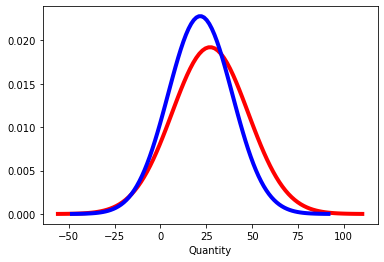

In [19]:
#Discount
xs, ys = evaluate_PDF(discounted_rv)
plt.plot(xs, ys, label='discounted', linewidth=4, color='red') 

#No Discount
xs, ys = evaluate_PDF(no_discount_rv)
plt.plot(xs, ys, label='no_discount', linewidth=4, color='blue')

plt.xlabel('Quantity')

In [20]:
#Seeding a random sample size using my two sample populations as parameters to find Simple Effect Size
discounted_sample = discounted_rv.rvs(1000)
mean1, std1 = discounted.mean(), discounted.std()
no_discount_sample = no_discount_rv.rvs(1000)
mean2, std2 = no_discount.mean(), no_discount.std()
mean2, std2, mean1, std1

(0    21.715262
 dtype: float64, 0    17.507493
 dtype: float64, 0    27.109785
 dtype: float64, 0    20.771439
 dtype: float64)

In [21]:
#Calculating the difference in means
difference_in_means = discounted.mean() - no_discount.mean()
difference_in_means

0    5.394523
dtype: float64

In [22]:
#Now I'd like to find the magnitude of the difference and will start with looking at the relative difference
#as a percentage
relative_difference = difference_in_means / discounted.mean()
relative_difference1 = difference_in_means / no_discount.mean()
relative_difference * 100, relative_difference1 * 100

(0    19.898805
 dtype: float64, 0    24.842082
 dtype: float64)

So depending on which variable you weigh it against, there is approximately a 22% difference of effect in quantity
purchased depending on if there is a discount. This seems significant although the P-score was much larger than the alpha to prove significance.

In [23]:
#Create function to detect overlap and probability of superiority
def overlap_superiority(group1, group2, n=1000):
    """Estimates overlap and superiority based on a sample.
    
    group1: scipy.stats rv object
    group2: scipy.stats rv object
    n: sample size
    """

    # Get a sample of size n from both groups
    group1_sample = group1.rvs(n)
    group2_sample = group2.rvs(n)
    
    # Identify the threshold between samples
    thresh = (group1.mean() + group2.mean()) / 2
    print(thresh)
    
    # Calculate no. of values above and below for group 1 and group 2 respectively
    above = sum(group1_sample < thresh)
    below = sum(group2_sample > thresh)
    
    # Calculate the overlap
    overlap = (above + below) / n
    
    # Calculate probability of superiority
    superiority = sum(x > y for x, y in zip(group1_sample, group2_sample)) / n

    return overlap, superiority

In [24]:
overlap_superiority(discounted_rv, no_discount_rv, n=1000)

[24.41252358]


(0.862, 0.571)

So we have an overlap of 86% (very high) and a 57% probability of superiority (relatively low)

Finally, I want to measure effect size from a standardized perspective and will create a function for Cohen's D to
do just that.

In [25]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [26]:
Cohen_d(discounted_sample, no_discount_sample)

0.2860842424285282

So we have a .28 standard deviations effect size difference between the two samples.

In [27]:
#Visualization function for Cohen's D
def plot_pdfs(cohen_d=2):
    """Plot PDFs for distributions that differ by some number of stds.
    
    cohen_d: number of standard deviations between the means
    """
    group1 = scipy.stats.norm(0, 1)
    group2 = scipy.stats.norm(cohen_d, 1)
    xs, ys = evaluate_PDF(group1)
    plt.fill_between(xs, ys, label='Group1', color='#ff2289', alpha=0.7)

    xs, ys = evaluate_PDF(group2)
    plt.fill_between(xs, ys, label='Group2', color='#376cb0', alpha=0.7)
    
    o, s = overlap_superiority(group1, group2)
    print('overlap', o)
    print('superiority', s)

0.14
overlap 1.106
superiority 0.417


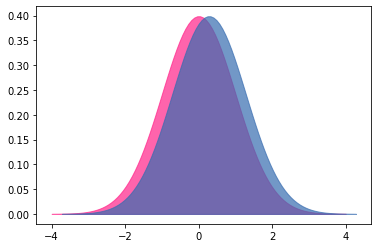

In [28]:
plot_pdfs(.28)

In [29]:
#Now that the data is normalized, I will go through the steps to define and run Welch's T-Test on my data
#as the sample sizes are > 30 by a long-shot and they are also not equal.
def welch_t(a, b):
    
    """ Calculate Welch's t statistic for two samples. """

    numerator = a.mean() - b.mean()
    
    # “ddof = Delta Degrees of Freedom”: the divisor used in the calculation is N - ddof, 
    #  where N represents the number of elements. By default ddof is zero.
    
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    
    return np.abs(numerator/denominator)

welch_t(discounted_yj, no_discount_yj)

0.4731820872613352

In [30]:
def welch_df(a, b):
    
    """ Calculate the effective degrees of freedom for two samples. """
    
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator

welch_df(discounted_yj, no_discount_yj)

908.1145243970324

In [31]:
t = welch_t(discounted_yj, no_discount_yj)
df = welch_df(discounted_yj, no_discount_yj)

In [32]:
import scipy.stats as stats
def p_value(a, b, two_sided=False):

    t = welch_t(a, b)
    df = welch_df(a, b)
    
    p = 1-stats.t.cdf(np.abs(t), df)
    
    if two_sided:
        return 2*p
    else:
        return p

In [35]:
p_value(discounted_yj, no_discount_yj, two_sided=False)

0.31809849624052855

I can conclude that because the P-Value is greater than the alpha, I cannot reject the null hypothesis.

Additionally, the effect scores indicate that a discount is not very effective to measure effect and has far too much overlap to be considered significant.

Second Question:

What Effect Sizes are present amongst the different levels of discounts

In [114]:
#Inspect different discount levels
df1.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [115]:
#Create different Sample Sizes by Discount level
six_and_under = pd.DataFrame(cur.execute("""SELECT Quantity FROM OrderDetail WHERE Discount <= 0.06;"""))
ten_percent = pd.DataFrame(cur.execute("""SELECT Quantity FROM OrderDetail WHERE Discount = 0.10;"""))
twenty_percent = pd.DataFrame(cur.execute("""SELECT Quantity FROM OrderDetail WHERE Discount = 0.20;"""))
fifteen_percent = pd.DataFrame(cur.execute("""SELECT Quantity FROM OrderDetail WHERE Discount = 0.15;"""))
twenty_five_plus = pd.DataFrame(cur.execute("""SELECT Quantity FROM OrderDetail WHERE Discount = 0.25;"""))

In [116]:
#Create a loop to inspect all of the sample sizes using Yeo_Johnson Normalization model and train-test split...
#analyzing P values
np.random.seed(10)
distributions = [
    ('six_and_under', six_and_under),
    ('ten_percent', ten_percent),
    ('twenty_percent', twenty_percent),
    ('fifteen_percent', fifteen_percent),
    ('twenty_five_plus', twenty_five_plus)
]
for distribution in distributions:
    name, Z = distribution
    Z_train, Z_test = train_test_split(Z, test_size=.5)
    Z_trans_yj = yj.fit(Z_train).transform(Z_test)
    print(name, p_value(Z_trans_yj, no_discount_yj))

six_and_under 0.06603886659739111
ten_percent 0.3549941212371839
twenty_percent 0.2910217135873263
fifteen_percent 0.005887991732916875
twenty_five_plus 0.15705726034048417


The only statistically signifacant category of discounts, where we can reject the null hypothesis is when the discount is 25% or higher. The next closes, with a P value of .06 (just missing the alpha value) is the 20% off category.

Interestingly, the 6% and under category is more significant that either the 10 or 15% categories.

In [39]:
#<= 6% Effect Size Analysis vs. No Discount
np.random.seed(10)
six_and_under_mean = six_and_under.mean()
six_and_under_std = six_and_under.std()
six_and_under_rv = scipy.stats.norm(six_and_under_mean, six_and_under_std)
six_and_under_sample = six_and_under_rv.rvs(1000)
Cohen_d(six_and_under_sample, no_discount_sample)

0.034364241801685

In [40]:
#15% Effect Size Analysis vs. No Discount
np.random.seed(10)
fifteen_percent_mean = fifteen_percent.mean()
fifteen_percent_std = fifteen_percent.std()
fifteen_percent_rv = scipy.stats.norm(fifteen_percent_mean, fifteen_percent_std)
fifteen_percent_sample = fifteen_percent_rv.rvs(1000)
Cohen_d(fifteen_percent_sample, no_discount_sample)

0.35338642776219414

In [41]:
#10% Effect Size Analysis vs. No Discount
np.random.seed(10)
ten_percent_mean = ten_percent.mean()
ten_percent_std = ten_percent.std()
ten_percent_rv = scipy.stats.norm(ten_percent_mean, ten_percent_std)
ten_percent_sample = ten_percent_rv.rvs(1000)
Cohen_d(ten_percent_sample, no_discount_sample)

0.18237186628436483

In [42]:
#20% Effect Size Analysis vs. No Discount
np.random.seed(10)
twenty_percent_mean = twenty_percent.mean()
twenty_percent_std = twenty_percent.std()
twenty_percent_rv = scipy.stats.norm(twenty_percent_mean, twenty_percent_std)
twenty_percent_sample = twenty_percent_rv.rvs(1000)
Cohen_d(twenty_percent_sample, no_discount_sample)

0.29814360691695124

In [43]:
#>= 25% Effect Size Analysis vs. No Discount
np.random.seed(10)
twenty_five_plus_mean = twenty_five_plus.mean()
twenty_five_plus_std = twenty_five_plus.std()
twenty_five_plus_rv = scipy.stats.norm(twenty_five_plus_mean, twenty_five_plus_std)
twenty_five_plus_sample = twenty_five_plus_rv.rvs(1000)
Cohen_d(twenty_five_plus_sample, no_discount_sample)

0.3538956805577152

In [117]:
#Review differences in mean for presentation
print(six_and_under_mean, ten_percent_mean, fifteen_percent_mean, twenty_percent_mean, twenty_five_plus_mean)

0    22.380795
dtype: float64 0    25.236994
dtype: float64 0    28.382166
dtype: float64 0    27.024845
dtype: float64 0    28.24026
dtype: float64


In [86]:
difference_in_means2 = twenty_five_plus_mean - no_discount.mean()

#Now I'd like to find the magnitude of the difference and will start with looking at the relative difference
#as a percentage for the largest group
relative_difference2 = difference_in_means2 / twenty_five_plus.mean()
relative_difference3 = difference_in_means2 / no_discount.mean()
relative_difference2 * 100, relative_difference3 * 100

(0    23.105304
 dtype: float64, 0    30.047981
 dtype: float64)

So all in all, fairly effective differences in these values. Below is the largest significance visualization (25% discount).

0.176945
overlap 1.142
superiority 0.41


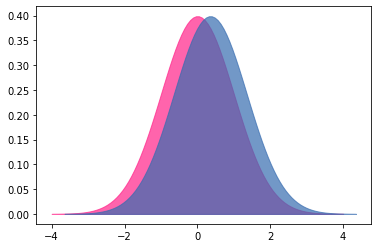

In [44]:
plot_pdfs(.35389)

Now I'm going to begin working on my own question #1.

H0 = There is no difference in Quantity of Items Sold in an Order based on the Country of the Employee doing the selling.

Ha = There is a significant difference between Quantity of Items sold in an Order based on Employee's being from the USA.

a = .05

In [47]:
#Connect to the database and create sample sizes for country = 'USA' and Not
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()
cur.execute("""SELECT OD.UnitPrice FROM "Order" O
                Inner JOIN OrderDetail OD on O.ID = OD.OrderID
                Left Join Employee E on O.EmployeeID = E.ID
                Where E.Country = 'USA'
                Group By OD.OrderID;
               """)
Q1_USA = pd.DataFrame(cur.fetchall())
Q1_USA.columns = [x[0] for x in cur.description]
Q1_USA.head()

,UnitPrice
0,7.7
1,16.8
2,64.8
3,10.0
4,26.2


In [48]:
Q1_USA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606 entries, 0 to 605
Data columns (total 1 columns):
UnitPrice    606 non-null float64
dtypes: float64(1)
memory usage: 4.9 KB


In [49]:
cur.execute("""SELECT OD.UnitPrice FROM "Order" O
                Inner JOIN OrderDetail OD on O.ID = OD.OrderID
                Left Join Employee E on O.EmployeeID = E.ID
                Where E.Country != 'USA'
                Group By OD.OrderID;
               """)
Q1_UK = pd.DataFrame(cur.fetchall())
Q1_UK.columns = [x[0] for x in cur.description]
Q1_UK.head()

,UnitPrice
0,14.0
1,18.6
2,3.6
3,15.2
4,13.9


In [50]:
# seed the random number generator so I get the same results
np.random.seed(10)

#Mean height and sd for discounted quantities
Q1_UK_mean = Q1_UK.mean()
Q1_UK_sd = Q1_UK.std()

# Generate a normal distribution for discounted quantities
Q1_UK_rv = scipy.stats.norm(Q1_UK_mean, Q1_UK_sd)

#Mean height and sd for discounted quantities
Q1_USA_mean = Q1_USA.mean()
Q1_USA_sd = Q1_USA.std()

# Generate a normal distribution for discounted quantities
Q1_USA_rv = scipy.stats.norm(Q1_USA_mean, Q1_USA_sd)

Text(0.5, 0, 'Quantity')

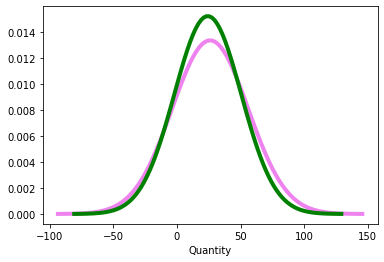

In [64]:
#Discount
xs, ys = evaluate_PDF(Q1_USA_rv)
plt.plot(xs, ys, label='discounted', linewidth=4, color='violet') 

#No Discount
xs, ys = evaluate_PDF(Q1_UK_rv)
plt.plot(xs, ys, label='no_discount', linewidth=4, color='green')

plt.xlabel('Quantity')

Now I'm going to begin working on my own question #2.

H0 = There is no difference in Quantity of Items Sold vs. Unit Price below or equal to 26 (mean)

Ha = There is a significant difference between Quantity of Items sold vs. Unit Price below or equal to 26 (mean)

a = .05

In [93]:
Q2_twentysix_below = pd.DataFrame(cur.execute("""SELECT Quantity FROM OrderDetail
                                                Where UnitPrice <= 26.00;"""))

In [94]:
Q2_greaterthan_twentysix = pd.DataFrame(cur.execute("""SELECT Quantity FROM OrderDetail
                                                    Where UnitPrice > 26.00;"""))

In [100]:
# seed the random number generator so I get the same results
np.random.seed(10)

#Mean height and sd for discounted quantities
Q2_twentysix_below_mean = Q2_twentysix_below.mean()
Q2_twentysix_below_sd = Q2_twentysix_below.std()

# Generate a normal distribution for discounted quantities
Q2_twentysix_below_rv = scipy.stats.norm(Q2_twentysix_below_mean, Q2_twentysix_below_sd)

In [101]:
# seed the random number generator so I get the same results
np.random.seed(10)

#Mean height and sd for discounted quantities
Q2_greaterthan_twentysix_mean = Q2_greaterthan_twentysix.mean()
Q2_greaterthan_twentysix_sd = Q2_greaterthan_twentysix.std()

# Generate a normal distribution for discounted quantities
Q2_greaterthan_twentysix_rv = scipy.stats.norm(Q2_greaterthan_twentysix_mean, Q2_greaterthan_twentysix_sd)

Text(0.5, 0, 'Quantity')

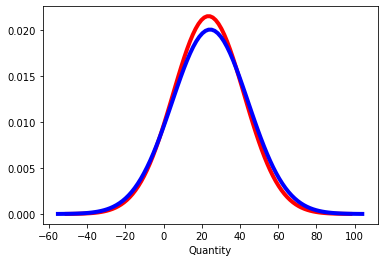

In [102]:
#Discount
xs, ys = evaluate_PDF(Q2_twentysix_below_rv)
plt.plot(xs, ys, label='discounted', linewidth=4, color='red') 

#No Discount
xs, ys = evaluate_PDF(Q2_greaterthan_twentysix_rv)
plt.plot(xs, ys, label='no_discount', linewidth=4, color='blue')

plt.xlabel('Quantity')

Now I'm going to begin working on my own question #3.

H0 = There is no difference in Quantity of Items Sold vs. Country of Origin for the Supplier

Ha = There is a significant difference between Quantity of Items sold vs. Country of Origin for the Supplier

a = .05

In [76]:
cur.execute("""SELECT Quantity FROM OrderDetail OD
                Inner Join Product P on P.ID = OD.ProductID
                Inner Join Supplier S on S.ID = P.SupplierID
                Where S.Country = 'USA';
               """)
Q3_USA = pd.DataFrame(cur.fetchall())
Q3_USA.columns = [x[0] for x in cur.description]
Q3_USA.head()

,Quantity
0,10
1,15
2,20
3,65
4,16


In [78]:
Q3_USA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 1 columns):
Quantity    277 non-null int64
dtypes: int64(1)
memory usage: 2.3 KB


In [73]:
cur.execute("""SELECT Quantity FROM OrderDetail OD
                Inner Join Product P on P.ID = OD.ProductID
                Inner Join Supplier S on S.ID = P.SupplierID
                Where S.Country = 'Japan';
               """)
Q3_Jap = pd.DataFrame(cur.fetchall())
Q3_Jap.columns = [x[0] for x in cur.description]
Q3_Jap.head()

,Quantity
0,9
1,21
2,36
3,24
4,15


In [79]:
cur.execute("""SELECT Quantity FROM OrderDetail OD
                Inner Join Product P on P.ID = OD.ProductID
                Inner Join Supplier S on S.ID = P.SupplierID
                Where S.Country = 'Spain';
               """)
Q3_Spain = pd.DataFrame(cur.fetchall())
Q3_Spain.columns = [x[0] for x in cur.description]
cur.execute("""SELECT Quantity FROM OrderDetail OD
                Inner Join Product P on P.ID = OD.ProductID
                Inner Join Supplier S on S.ID = P.SupplierID
                Where S.Country = 'UK';
               """)
Q3_UK = pd.DataFrame(cur.fetchall())
Q3_UK.columns = [x[0] for x in cur.description]
print(Q3_UK.info(), Q3_Spain.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 1 columns):
Quantity    220 non-null int64
dtypes: int64(1)
memory usage: 1.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 1 columns):
Quantity    52 non-null int64
dtypes: int64(1)
memory usage: 544.0 bytes
None None


In [84]:
# seed the random number generator so I get the same results
np.random.seed(10)

#Mean height and sd for discounted quantities
Q3_USA_mean = Q3_USA.mean()
Q3_USA_sd = Q3_USA.std()

# Generate a normal distribution for USA
Q3_USA_rv = scipy.stats.norm(Q3_USA_mean, Q3_USA_sd)

#Mean height and sd for discounted quantities
Q3_Jap_mean = Q3_Jap.mean()
Q3_Jap_sd = Q3_Jap.std()

# Generate a normal distribution for USA
Q3_Jap_rv = scipy.stats.norm(Q3_Jap_mean, Q3_Jap_sd)

#Mean height and sd for discounted quantities
Q3_Spain_mean = Q3_Spain.mean()
Q3_Spain_sd = Q3_Spain.std()

# Generate a normal distribution for USA
Q3_Spain_rv = scipy.stats.norm(Q3_Spain_mean, Q3_Spain_sd)

#Mean height and sd for discounted quantities
Q3_UK_mean = Q3_UK.mean()
Q3_UK_sd = Q3_UK.std()

# Generate a normal distribution for USA
Q3_UK_rv = scipy.stats.norm(Q3_UK_mean, Q3_UK_sd)

Text(0.5, 0, 'Quantity')

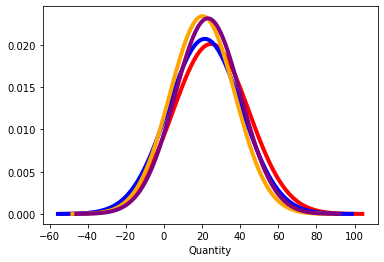

In [85]:
#USA
xs, ys = evaluate_PDF(Q3_USA_rv)
plt.plot(xs, ys, label='discounted', linewidth=4, color='red') 

#Japan
xs, ys = evaluate_PDF(Q3_Jap_rv)
plt.plot(xs, ys, label='no_discount', linewidth=4, color='blue')

#Spain
xs, ys = evaluate_PDF(Q3_Spain_rv)
plt.plot(xs, ys, label='no_discount', linewidth=4, color='orange')

#UK
xs, ys = evaluate_PDF(Q3_UK_rv)
plt.plot(xs, ys, label='no_discount', linewidth=4, color='Purple')

plt.xlabel('Quantity')

In [113]:
(Q3_USA_mean - Q3_Jap_mean) / Q3_USA_mean * 100

Quantity    13.033948
dtype: float64

In [125]:
#Creating random samples from my populations to run against Cohen's D
Q3_USA_sample = Q3_USA_rv.rvs(1000)
Q3_Jap_sample = Q3_Jap_rv.rvs(1000)
Q3_Spain_sample = Q3_Spain_rv.rvs(1000)
Q3_UK_sample = Q3_UK_rv.rvs(1000)

In [126]:
Cohen_d(Q3_USA_sample, no_discount_sample)

0.1263318275296065

In [127]:
Cohen_d(Q3_Jap_sample, no_discount_sample)

-0.012855248438220078

In [128]:
Cohen_d(Q3_Spain_sample, no_discount_sample)

-0.12622426743024112

In [129]:
Cohen_d(Q3_UK_sample, no_discount_sample)

0.04781186830765736

Conclusions:

-Any Discount has about a 22% efect increase on quantity sold according to Welch's T and Cohen's D's tests.

-Discount level of 25% and 15% have highest increase in quantity sold effect (27%) vs. no-discount groups

-Employee Country of sale has no significant, nor effective impact on quantity sold

-Unit Price below or over the mean does not have any significant nor effective impact on quantity sold either.

-Products whose suppliers are based in the USA have a 13% effective impact on quantity sold according to Cohen's D statistical test.